In [14]:
# load classified rasters 

import rasterio 
import glob

from pprint import pprint

In [15]:
# find files in classification folder
raster_files_path = '../../TreeTect/data/raster_classifications/*.tif'
raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files[0:5])
print('-------------------------------------')
print(file_path)

1
-------------------------------------
['../../TreeTect/data/raster_classifications/classification_Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500.tif']
-------------------------------------
../../TreeTect/data/raster_classifications/classification_Medan_168_pansharpen_True_2020-03-03_04:05_10300100A367E500.tif


In [16]:
data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

transform = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

In [20]:
data.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]])

In [38]:
import numpy as np
# scikit-image modules for image science operators


In [39]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 80.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

80.0 sq. m
500 grid cells


In [40]:
# First, remove the small holes
water_cleaned = morphology.remove_small_holes(data.astype(int), min_feature_size_cells / 4)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)


/home/chris/anaconda3/envs/FNC_1/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  


In [41]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Cleaned Water Mask')

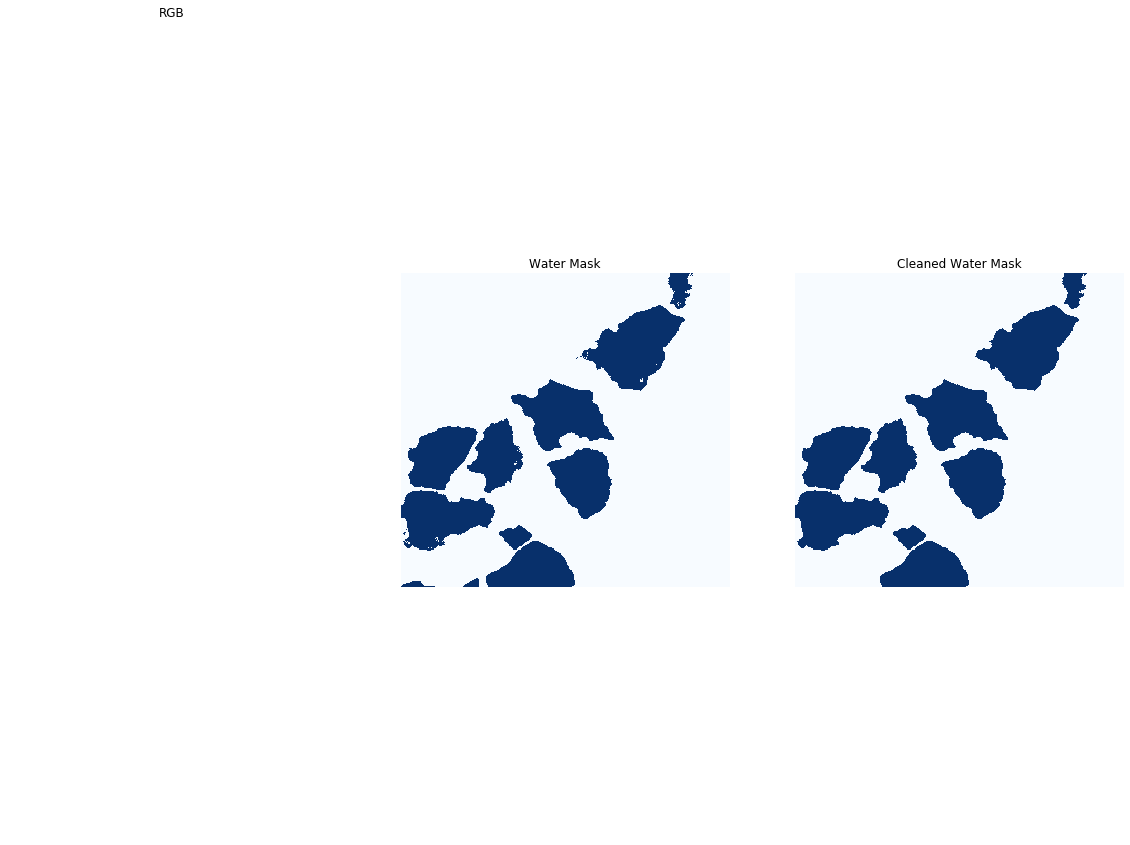

In [42]:
# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 3, 1)
plt.axis('off')
# plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(data[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(water_cleaned[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

In [55]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
import itertools

def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = [g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 


In [56]:
try: 
    affine = image.affine
except:
    affine = dataset.meta['transform']

In [57]:
affine

Affine(4.8059647862019405e-06, 0.0, 98.66632667971254,
       0.0, -4.8059647862019405e-06, 3.491774586413942)

In [58]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]

In [82]:
water_lines

In [59]:
water_lines_smooth

In [61]:
from shapely.ops import cascaded_union

In [62]:
# GLue it all together
setu = cascaded_union(water_lines)

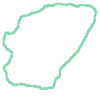

In [268]:
setu[14]

In [64]:
s = setu.simplify(0.00001, preserve_topology=False)

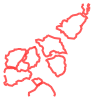

In [65]:
s

In [68]:
import folium

In [70]:
from shapely.ops import transform
from shapely import ops
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:32750'),
    pyproj.Proj(init='epsg:4326'))



setu_wgs = transform(project, setu)


setu_smooth = setu_wgs.simplify(0.00003)
setu_poly = ops.polygonize_full(setu_wgs)[0]

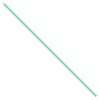

In [264]:
s[2]


In [270]:
m = folium.Map([s.centroid.y, s.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


# folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(setu_poly, name = 'exterior').add_to(m)

folium.Choropleth(setu[14], name = 'hallo', line_color = 'white').add_to(m)

# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [271]:
m


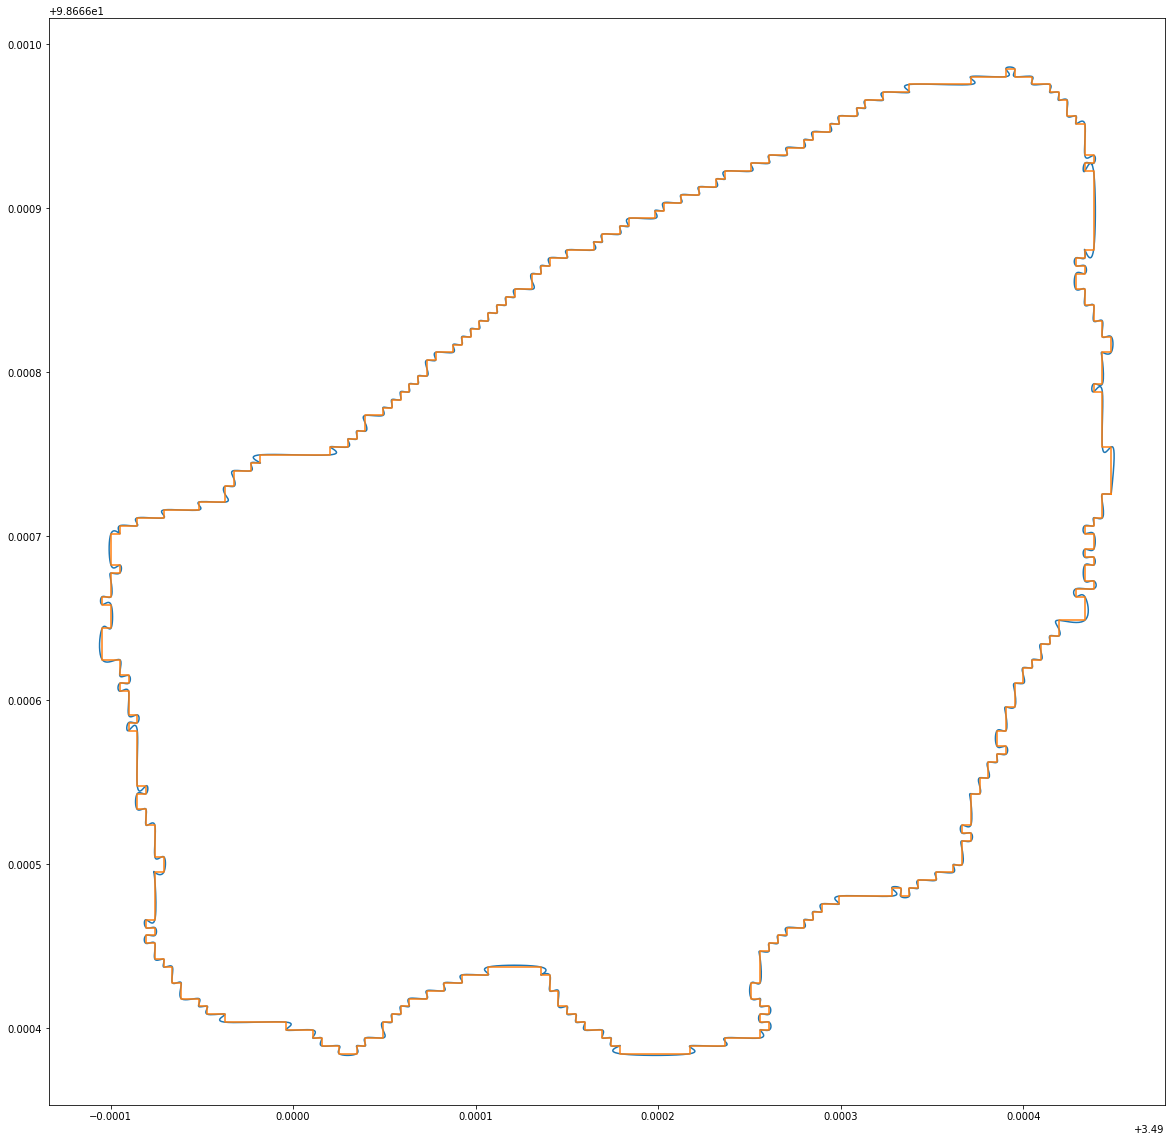

In [280]:
import scipy.interpolate as si

Multi = setu[14]

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

x = np.array(Multi.coords[:])[:,1]
y = np.array(Multi.coords[:])[:,0]

t = np.arange(len(x))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, x, kind='cubic')(ti)
yi = interp1d(t, y, kind='cubic')(ti)

fig, ax = plt.subplots(figsize = (20,20))
ax.plot(xi, yi, )
ax.plot(x, y)
ax.margins(0.05)
plt.show()

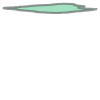

In [273]:
setu_poly[13]

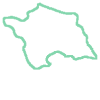

In [274]:
setu[10]

In [275]:
points  = np.array([point for point in Multi.coords])

/home/chris/anaconda3/envs/FNC_1/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


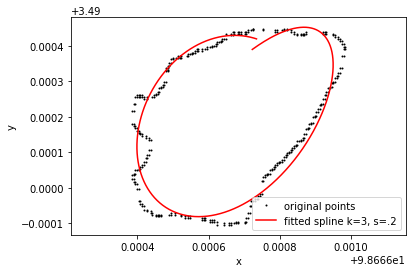

In [290]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline

# # Define some points:
# theta = np.linspace(-3, 2, 40)
# points = np.vstack( (np.cos(theta), np.sin(theta)) ).T

# # add some noise:
# points = points + 0.05*np.random.randn(*points.shape)

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Build a list of the spline function, one for each dimension:
splines = [UnivariateSpline(distance, coords, k=5, s=2) for coords in points.T]

# splines.set_smoothing_factor(0.5)

# Computed the spline for the asked distances:
alpha = np.linspace(0,1,1000)
points_fitted = np.vstack( spl(alpha) for spl in splines ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points',  markersize = 1);
plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

In [277]:
#
# Splining a polygon.
#
#   The rows of 'xy' give coordinates of the boundary vertices, in order.
#   'vertices' is the number of spline vertices to create.
#              (Not all are used: some are clipped from the ends.)
#   'k' is the number of points to wrap around the ends to obtain
#       a smooth periodic spline.
#
#   Returns an array of points. 
# 
spline.poly <- function(xy, vertices, k=3, ...) {
    # Assert: xy is an n by 2 matrix with n >= k.

    # Wrap k vertices around each end.
    n <- dim(xy)[1]
    if (k >= 1) {
        data <- rbind(xy[(n-k+1):n,], xy, xy[1:k, ])
    } else {
        data <- xy
    }

    # Spline the x and y coordinates.
    data.spline <- spline(1:(n+2*k), data[,1], n=vertices, ...)
    x <- data.spline$x
    x1 <- data.spline$y
    x2 <- spline(1:(n+2*k), data[,2], n=vertices, ...)$y

    # Retain only the middle part.
    cbind(x1, x2)[k < x & x <= n+k, ]
}

SyntaxError: invalid syntax (<ipython-input-277-eed3912c12d1>, line 12)

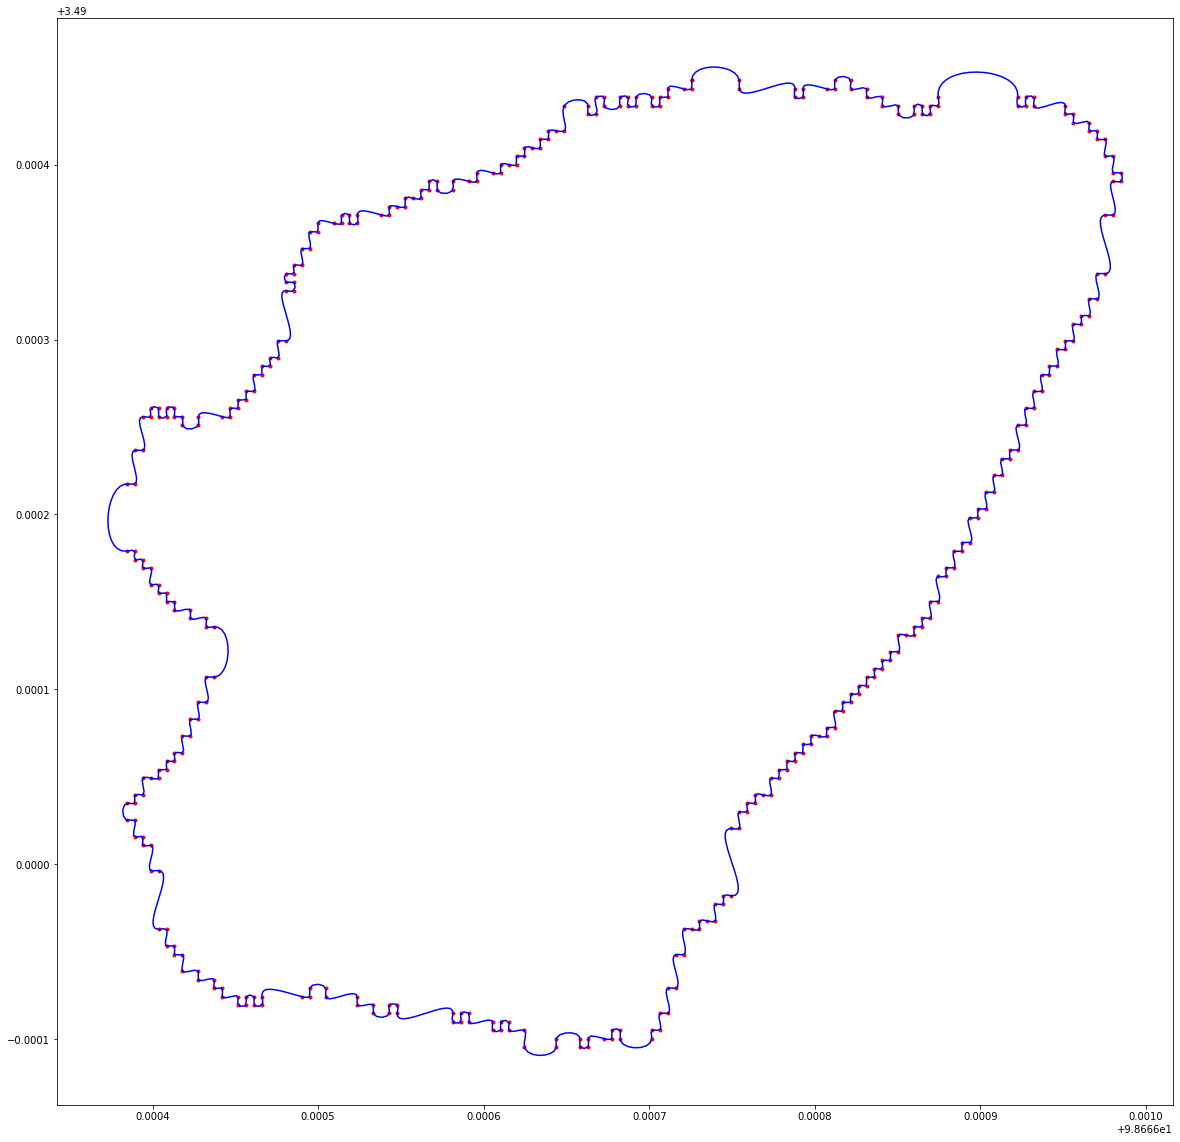

In [289]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# define pts from the question
pts = points

tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
u_new = np.linspace(u.min(), u.max(), 1000)            
x_new, y_new = splev(u_new, tck, der=0)

fig, ax = plt.subplots(figsize = (20,20))
plt.plot(pts[:,0], pts[:,1], 'r.')
plt.plot(x_new, y_new, 'b-')
plt.show()